<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/pairs_trading_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Commodities Mean Reversion Trading Strategy

In it's most simple form, all trading strategies can be classified as either momentum or mean reversion. Commodities are often fungible, that is interchangeable to a certain degree. This in turn implies both a positive correlation, as well as cointegration, between a select number of commodity pairs. This project will explore a mean reverting pairs trading strategy between two commodities. For illustrative purposes, the commodities chosen are CME corn and SRW wheat futures applied to the continuous futures front month contract.

### Import libraries

In [1]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# financial analysis
import yfinance as yf #Yahoo! Finance API
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# surpress warnings
pd.options.mode.chained_assignment = None # chained assignments

### User defined date range and trading pair

In [2]:
# date range
start = '2012-01-01' # YYYY-MM-DD format
end = datetime.now() - timedelta(1)

# trading pair
# product1_ticker = 'ZC=F'
# product1_name = 'Corn'
product1_ticker = 'KE=F'
product1_name = 'HRW'
product2_ticker = 'ZW=F'
product2_name = 'SRW'

### Fetching price data

In [3]:
# fetching data for first product
data1 = yf.download(product1_ticker, start=start, end=end)
data1.rename(columns={'Adj Close':product1_name}, inplace=True)

# fetching data for second product
data2 = yf.download(product2_ticker, start=start, end=end)
data2.rename(columns={'Adj Close':product2_name}, inplace=True)

# creating a price dataframe
prices = pd.concat([data1[product1_name], data2[product2_name]], axis=1)
prices.fillna(method='ffill', inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Making the series stationary

In order to implement a mean reverting strategy we first have to ensure our data is stationary, which simply means a constant mean and variance. A simple test is a quick visual inspection, however a more robust statistical test is the Augmented Dicky-Fuller (ADF) test. A typical $a$ is 0.05 and we reject the null hypothesis, i.e. fail to reject our alternative hypothesis that our data is non-stationary, when our p-value is below this threshold.

#### Price ratio

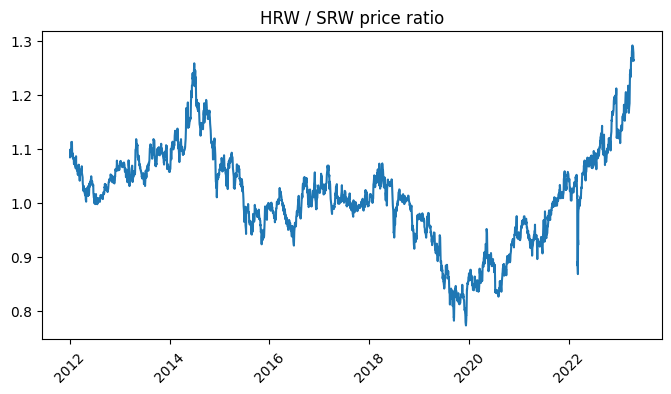

ADF statistic:
-1.441202 

p-value: 
0.562372 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


In [4]:
# calculate ratio
ratio = prices[product1_name] / prices[product2_name]

# plot ratio
plt.subplots(figsize=(8, 4))
plt.plot(ratio.index, ratio)
plt.title(f'{product1_name} / {product2_name} price ratio')
plt.xticks(rotation=45)
plt.show()

# checking for stationarity
result = adfuller(ratio)
print('ADF statistic:\n%f' % result[0], '\n')
print('p-value: \n%f' % result[1], '\n')
print('Critical values:')
for key, value in result[4].items():
  print('%s @ %.3f' % (key, value))

#### Price ratio log returns

In order to make our series stationary we perform a log transformation followed by differencing $t$ and $t_{-1}$, which gives us log returns.

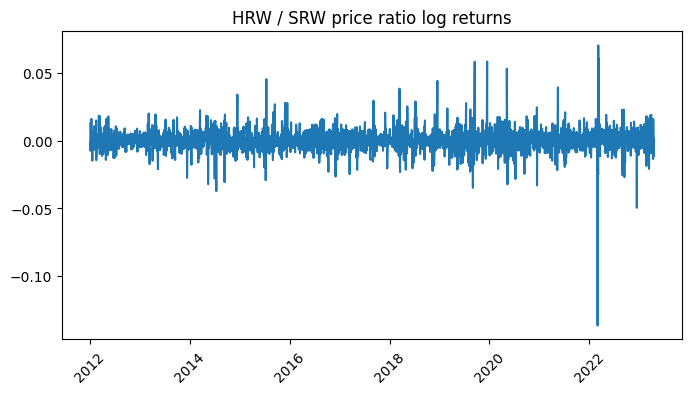

ADF statistic:
-26.484607 

p-value: 
0.000000 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


In [5]:
# calculate log returns
ratio_log_returns = np.log(ratio).diff().dropna()

# plot log returns
plt.subplots(figsize=(8, 4))
plt.plot(ratio_log_returns.index, ratio_log_returns)
plt.title(f'{product1_name} / {product2_name} price ratio log returns')
plt.xticks(rotation=45)
plt.show()

# checking for stationarity
result = adfuller(ratio_log_returns)
print('ADF statistic:\n%f' % result[0], '\n')
print('p-value: \n%f' % result[1], '\n')
print('Critical values:')
for key, value in result[4].items():
	print('%s @ %.3f' % (key, value))

### Trading strategy

Our base strategy is essentially a Bollinger Bands strategy, which means only a few adjustable hyperparameters, namely the lookback window and standard deviation. Another potential adjustment is whether to use a SMA or EWMA, which we will leave as a future exercise.

#### User defined hyperparameters

In [6]:
# hyperparameters
window = 30
std = 3

In [7]:
# calculating rolling mean and std
df = pd.DataFrame(ratio_log_returns, columns=['log_returns'])
df['mean'] = df['log_returns'].rolling(window=window).mean()
df['std'] = df['log_returns'].rolling(window=window).std()
df['upper_band'] = df['mean'] + std * df['std']
df['lower_band'] = df['mean'] - std * df['std']

#### Bollinger Bands

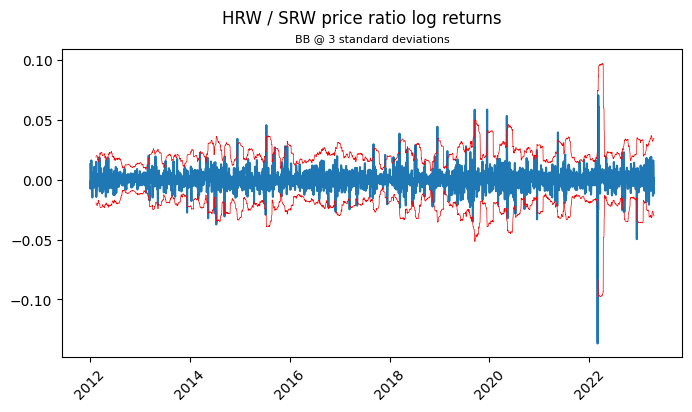

In [8]:
# plot bollinger bands
plt.subplots(figsize=(8, 4))
plt.plot(ratio_log_returns.index, ratio_log_returns)
plt.plot(ratio_log_returns.index, df['upper_band'], color='r', linewidth=0.5)
plt.plot(ratio_log_returns.index, df['lower_band'], color='r', linewidth=0.5)
plt.suptitle(f'{product1_name} / {product2_name} price ratio log returns')
plt.title(f'BB @ {std} standard deviations', fontsize=8)
plt.xticks(rotation=45)
plt.show()

#### Setting up entry and exit rules

In [9]:
# add signal column to dataframe
df['signal'] = 0

# define trading rules
for i in range(1, len(df)):
  
  # from hold to (sell or buy)
  if df['signal'][i] == 0:
    if (df['log_returns'][i-1] > df['upper_band'][i-1]) and \
          (df['log_returns'][i] <= df['upper_band'][i]):
       df['signal'][i] = -1
    elif (df['log_returns'][i-1] < df['lower_band'][i-1]) and \
          (df['log_returns'][i] >= df['upper_band'][i]):
       df['signal'][i] = 1
  
  # from sell to hold
  elif df['signal'][i] == -1:
    if (df['log_returns'][i-1] > df['mean'][i-1]) and \
          (df['log_returns'][i] <= df['mean'][i]):
       df['signal'][i] = 0
  
  # from buy to hold
  elif df['signal'][i] == 1:
    if (df['log_returns'][i-1] < df['mean'][i-1]) and \
          (df['log_returns'][i] >= df['mean'][i]):
       df['signal'][i] = 0

# plot signal
# plt.subplots(figsize=(8, 4))
# df['signal'].plot();

In [10]:
# df['signal'].value_counts()

### Notes

Explanatory variables:
- Log returns of price ratio
- Volume, OI for each leg
- Call and put options volume, OI for each leg
- Options net delta
- Other correlated commodities prices
- WTI, Brent prices
- GSCI, S&P500
- VIX
- USD/EUR, USD/AUD, USD/CAD, USD/BRL

*Note: For all above variables their $n$ lagged values may be considered.*

# END